In [1]:
import numpy as np
import cv2
import glob
import time
from collections import deque
import _pickle as cPickle

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog

from scipy.ndimage.measurements import label

# Eliminating warning messages
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

### Helper functions 
Modified from codes in Udacity lectures

In [2]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def convert_RGB(img, color_space):
    try:
        flag = getattr(cv2, "COLOR_RGB2"+color_space)
        return cv2.cvtColor(img, flag)
    except:
        return np.copy(img)
    
# Define a function to extract features from a single image window
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    feature_image = convert_RGB(img, color_space)
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        file_features = single_img_features(image, 
                                            color_space=color_space, 
                                            spatial_size=spatial_size,
                                            hist_bins=hist_bins, 
                                            orient=orient, 
                                            pix_per_cell=pix_per_cell, 
                                            cell_per_block=cell_per_block, 
                                            hog_channel=hog_channel,
                                            spatial_feat=spatial_feat, 
                                            hist_feat=hist_feat, 
                                            hog_feat=hog_feat)
        features.append(file_features)
    # Return list of feature vectors
    return features

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        #test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scales, clf, cells_per_steps, color_space,
              spatial_size=(32, 32), hist_bins=32, orient=9, 
              pix_per_cell=8, cell_per_block=2, hog_channel=0,
              spatial_feat=True, hist_feat=True, hog_feat=True):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_RGB(img_tosearch, color_space)
    for cell_per_step, scale in zip(cells_per_steps, scales):
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

        # Define blocks and steps as above
        nxblocks = (ctrans_tosearch.shape[1] // pix_per_cell) - cell_per_block + 1
        nyblocks = (ctrans_tosearch.shape[0] // pix_per_cell) - cell_per_block + 1 
        nfeat_per_block = orient*cell_per_block**2

        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        # Compute individual channel HOG features for the entire image
        channels = [0,1,2] if hog_channel == "ALL" else list(hog_channel)
        hog_features = []
        for ch in channels:
            hog_features.append(get_hog_features(
                ctrans_tosearch[:,:,ch], orient, pix_per_cell, cell_per_block, feature_vec=False))

        for xb in range(nxsteps):
            for yb in range(nysteps):
                features = []
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                hogf = []
                for hf in hog_features:
                    hogf.extend(hf[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel())
                features.append(hogf)

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

                # Get color features
                if spatial_feat:
                    features.append(bin_spatial(subimg, size=spatial_size)) 
                if hist_feat:
                    features.append(hist_features = color_hist(subimg, nbins=hist_bins))

                # Scale features and make a prediction
                test_prediction = clf.predict(np.concatenate(features))    

                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    cv2.rectangle(draw_img,
                                  (xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),
                                  (0,0,255), 6)
    return draw_img

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    bbox_list = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bbox_list.append(bbox)
    # Return box list
    return bbox_list

### Read in data sets

Car images = 8792; Non car images = 8968


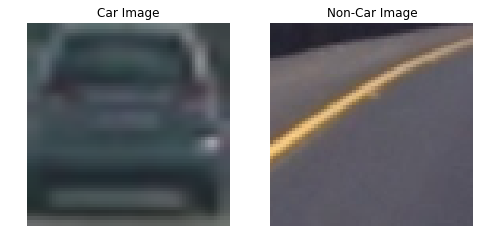

In [3]:
# Read in cars and notcars
car_images = glob.glob('data/vehicles/*/*.png')
non_car_images = glob.glob('data/non-vehicles/*/*.png')
print("Car images = %d; Non car images = %d" % (len(car_images), len(non_car_images)))
fig = plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(mpimg.imread(car_images[10]))
plt.axis('off')
plt.title('Car Image')
plt.subplot(1, 2, 2)
plt.imshow(mpimg.imread(non_car_images[10]))
plt.axis('off')
plt.title('Non-Car Image')

### Example of Histogram of Oriented Gradients (HOG)

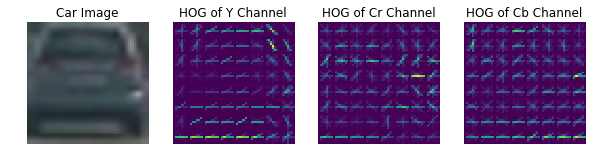

In [4]:
image = mpimg.imread(car_images[10])
image_YCrCb = convert_RGB(image, "YCrCb")
orient = 8  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_img = [0]*3
for channel in range(3):
    feature, hog_img[channel] = get_hog_features(image_YCrCb[:,:,channel], 
                                                orient=orient, 
                                                pix_per_cell=pix_per_cell, 
                                                cell_per_block=cell_per_block, 
                                                vis=True, feature_vec=False)

fig = plt.figure(figsize=(10, 5))
plt.subplot(1, 4, 1)
plt.imshow(image)
plt.axis('off')
plt.title('Car Image')
plt.subplot(1, 4, 2)
plt.imshow(hog_img[0])
plt.axis('off')
plt.title('HOG of Y Channel')
plt.subplot(1, 4, 3)
plt.imshow(hog_img[1])
plt.axis('off')
plt.title('HOG of Cr Channel')
plt.subplot(1, 4, 4)
plt.imshow(hog_img[2])
plt.axis('off')
plt.title('HOG of Cb Channel')

### Extract features and training

In [5]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 24    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off

start_time=time.time()
# Extract features
car_features = extract_features(car_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
non_car_features = extract_features(non_car_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# Create an array stack of feature vectors
X = np.vstack((car_features, non_car_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))

# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

clf = Pipeline([('scale', StandardScaler()),
                ('SVM', LinearSVC(loss='hinge')),
               ])

clf.fit(X_train, y_train)
print("Total time = %.5f" % (time.time() - start_time))
print("Accuracy = %.5f" % (clf.score(X_test, y_test)))

# save classifier
with open('YCrCb_hog.p', 'wb') as fid:
    cPickle.dump(clf, fid)

Total time = 77.20908
Accuracy = 0.97889


In [6]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 24    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off

# load classifier
with open('YCrCb_hog.p', 'rb') as fid:
    clf = cPickle.load(fid)

### Sliding window search

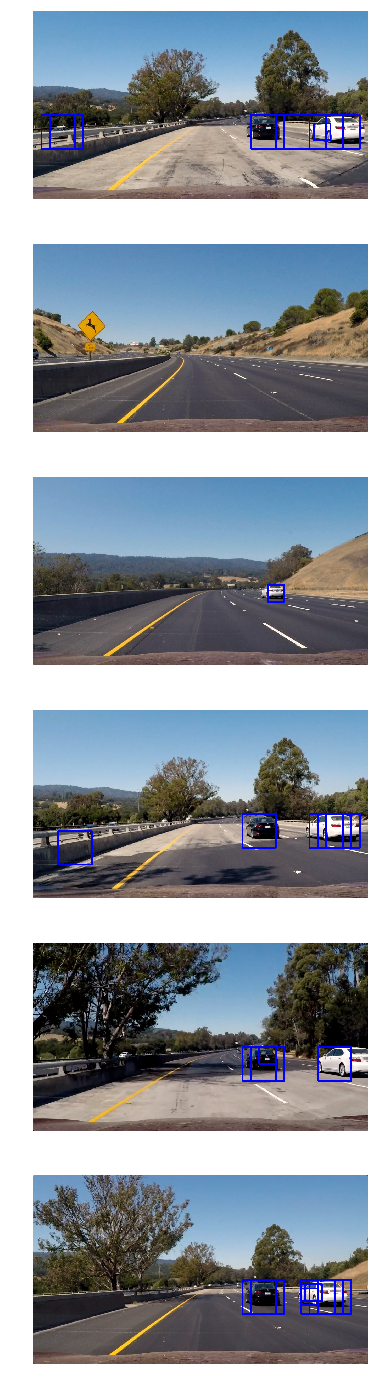

In [7]:
fig = plt.figure(figsize=(6, 25))
index = 1
for image_path in glob.glob('test_images/test*.jpg'):
    image = mpimg.imread(image_path)
    window_img = find_cars(image, 400, 640, [1,2], clf, cells_per_steps=[1,1], color_space=color_space, 
                           spatial_size=spatial_size, hist_bins=hist_bins, 
                           orient=orient, pix_per_cell=pix_per_cell, 
                           cell_per_block=cell_per_block, 
                           hog_channel=hog_channel, spatial_feat=spatial_feat, 
                           hist_feat=hist_feat, hog_feat=hog_feat)
    plt.subplot(6, 1, index)
    plt.imshow(window_img)
    plt.axis("off")
    index += 1

### Pipeline

In [4]:
def pipeline(img):
    global clf      # classifier
    global heatmap  # array of heatmaps
    global bbox_list  # array of bounding boxes for averaging
    global bbox_display  # bounding boxes for display on image
    
    ystart = 400
    ystop = 640
    xstart = 0
    xstop = 1280
    scales = [1, 2]
    cells_per_steps = [1, 1]
    color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 8  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
    spatial_size = (16, 16) # Spatial binning dimensions
    hist_bins = 24    # Number of histogram bins
    spatial_feat = False # Spatial features on or off
    hist_feat = False # Histogram features on or off
    hog_feat = True # HOG features on or off
    
    heatmap_frame = np.zeros(img.shape[:2])
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255    
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    ctrans_tosearch = convert_RGB(img_tosearch, color_space)
    for cell_per_step, scale in zip(cells_per_steps, scales):
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

        # Define blocks and steps as above
        nxblocks = (ctrans_tosearch.shape[1] // pix_per_cell) - cell_per_block + 1
        nyblocks = (ctrans_tosearch.shape[0] // pix_per_cell) - cell_per_block + 1 
        nfeat_per_block = orient*cell_per_block**2

        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        # Compute individual channel HOG features for the entire image
        channels = [0,1,2] if hog_channel == "ALL" else list(hog_channel)
        hog_features = []
        for ch in channels:
            hog_features.append(get_hog_features(
                ctrans_tosearch[:,:,ch], orient, pix_per_cell, cell_per_block, feature_vec=False))

        for xb in range(nxsteps):
            for yb in range(nysteps):
                features = []
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                hogf = []
                for hf in hog_features:
                    hogf.extend(hf[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel())
                features.append(hogf)

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

                # Get color features
                if spatial_feat:
                    features.append(bin_spatial(subimg, size=spatial_size)) 
                if hist_feat:
                    features.append(hist_features = color_hist(subimg, nbins=hist_bins))

                # Scale features and make a prediction
                test_prediction = clf.predict(np.concatenate(features))    

                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    heatmap_frame[ytop_draw+ystart:ytop_draw+win_draw+ystart, 
                                  xbox_left+xstart:xbox_left+win_draw+xstart] += 1
    if heatmap_frame.any():
        heatmap.append(heatmap_frame)
        heatmap_sum = np.sum(np.asarray(heatmap), axis=0)  # sum up all heatmaps in the array
        heatmap_sum[heatmap_sum<=3] = 0   # retain pixels that show up >3 times in the array
        if heatmap_sum.any():
            labels = label(heatmap_sum)
            box_list = draw_labeled_bboxes(draw_img, labels)
            bbox_list.append(box_list)
            # Average bounding boxes in the array
            # first step is to aggregate boxes based on distance between them
            for idx in range(len(box_list)):
                history = []
                for blist in bbox_list:
                    distances = [np.linalg.norm(
                        np.asarray(box_list[idx][0])-np.asarray(blist[ii][0])) for ii in range(len(blist))]
                    if np.min(distances) < 100:
                        # add box with smallest distance into group
                        history.append(blist[np.argmin(distances)])
                if len(history) > 0:
                    # finally calcuate average of bounding box
                    box_list[idx] = np.average(np.asarray(history), axis=0)
            bbox_display = box_list
    if bbox_display:
        for bbox in bbox_display:
            bbox = np.asarray(bbox, dtype=np.int)
            cv2.rectangle(draw_img, tuple(bbox[0]), tuple(bbox[1]), (0,0,255), 6)
    return draw_img

In [5]:
from moviepy.editor import VideoFileClip
import time

heatmap = deque(maxlen=15)
bbox_list = deque(maxlen=5)
bbox_display = None
all_bbox = []
#output = 'test_video_output.mp4'
#clip1 = VideoFileClip("test_video.mp4")
output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [09:59<00:00,  2.12it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 9min 59s


### Heatmap illustration

In [5]:
from moviepy.editor import VideoFileClip
import time

def pipeline2(img):
    global index
    mpimg.imsave("test/i%d.png"%index, img)
    index += 1
    return img

index = 0
output = 'test_video_output.mp4'
clip1 = VideoFileClip("test_video.mp4")
white_clip = clip1.fl_image(pipeline2) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:09<00:00,  4.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

Wall time: 10.4 s


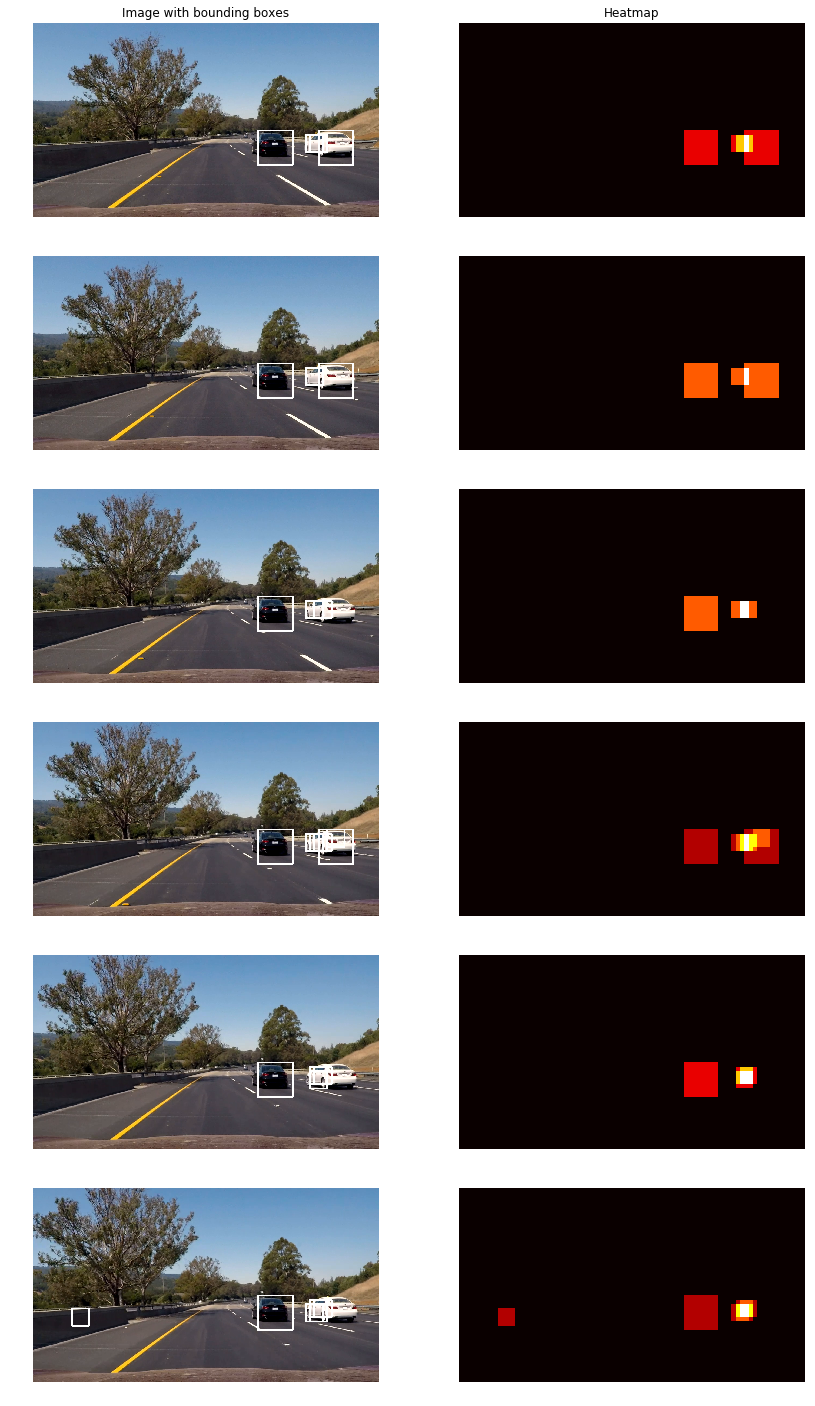

In [7]:
import os
fig = plt.figure(figsize=(14, 25))
idx = 1
heatmaps = []
for index in range(1,7):
    image_path = 'test/i%d.png' % index
    image = mpimg.imread(image_path)
    window_img, heatmap = find_cars2(image, 400, 640, [1,2], clf, cells_per_steps=[1,1], color_space=color_space, 
                               spatial_size=spatial_size, hist_bins=hist_bins, 
                               orient=orient, pix_per_cell=pix_per_cell, 
                               cell_per_block=cell_per_block, 
                               hog_channel=hog_channel, spatial_feat=spatial_feat, 
                               hist_feat=hist_feat, hog_feat=hog_feat)
    heatmaps.append(heatmap)
    plt.subplot(6, 2, idx)
    plt.imshow(window_img)
    plt.axis("off")
    if idx == 1:
        plt.title('Image with bounding boxes')
    idx += 1
    plt.subplot(6, 2, idx)
    plt.imshow(heatmap, cmap='hot')
    plt.axis("off")
    if idx == 2:
        plt.title('Heatmap')
    idx += 1

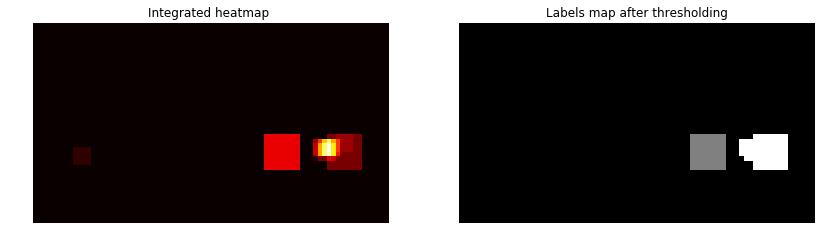

In [30]:
heatmap_sum = np.sum(np.asarray(heatmaps), axis=0)  # sum up all heatmaps in the array
fig = plt.figure(figsize=(14, 10))
plt.subplot(1, 2, 1)
plt.imshow(heatmap_sum, cmap='hot')
plt.axis("off")
plt.title("Integrated heatmap ")

heatmap_sum[heatmap_sum<=2] = 0   # retain pixels that show up >3 times in the array
labels = label(heatmap_sum)
plt.subplot(1, 2, 2)
plt.imshow(labels[0], cmap='gray')
plt.axis("off")
plt.title("Labels map after thresholding")

(-0.5, 1279.5, 719.5, -0.5)

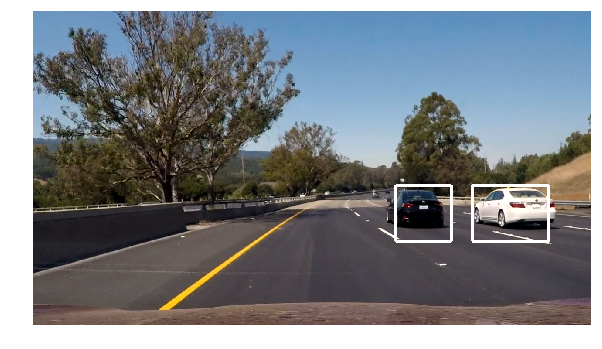

In [31]:
image_path = 'test/i%d.png' % 6
image = mpimg.imread(image_path)
box_list = draw_labeled_bboxes(image, labels)
for bbox in box_list:
    bbox = np.asarray(bbox, dtype=np.int)
    cv2.rectangle(image, tuple(bbox[0]), tuple(bbox[1]), (0,0,255), 6)
fig = plt.figure(figsize=(10, 6))
plt.imshow(image)
plt.axis("off")

In [4]:
def find_cars2(img, ystart, ystop, scales, clf, cells_per_steps, color_space,
              spatial_size=(32, 32), hist_bins=32, orient=9, 
              pix_per_cell=8, cell_per_block=2, hog_channel=0,
              spatial_feat=True, hist_feat=True, hog_feat=True):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    heatmap = np.zeros(img.shape[:2])
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_RGB(img_tosearch, color_space)
    for cell_per_step, scale in zip(cells_per_steps, scales):
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

        # Define blocks and steps as above
        nxblocks = (ctrans_tosearch.shape[1] // pix_per_cell) - cell_per_block + 1
        nyblocks = (ctrans_tosearch.shape[0] // pix_per_cell) - cell_per_block + 1 
        nfeat_per_block = orient*cell_per_block**2

        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        # Compute individual channel HOG features for the entire image
        channels = [0,1,2] if hog_channel == "ALL" else list(hog_channel)
        hog_features = []
        for ch in channels:
            hog_features.append(get_hog_features(
                ctrans_tosearch[:,:,ch], orient, pix_per_cell, cell_per_block, feature_vec=False))

        for xb in range(nxsteps):
            for yb in range(nysteps):
                features = []
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                hogf = []
                for hf in hog_features:
                    hogf.extend(hf[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel())
                features.append(hogf)

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

                # Get color features
                if spatial_feat:
                    features.append(bin_spatial(subimg, size=spatial_size)) 
                if hist_feat:
                    features.append(hist_features = color_hist(subimg, nbins=hist_bins))

                # Scale features and make a prediction
                test_prediction = clf.predict(np.concatenate(features))    

                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, 
                                  xbox_left:xbox_left+win_draw] += 1
                    cv2.rectangle(draw_img,
                                  (xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),
                                  (0,0,255), 6)
    return draw_img, heatmap